In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import json


def compute_tfidf(census, col_to_compute):
    """Compute TF-IDF scores for a column in the census. These scores are used to
    weight the string comparisons so that common adddresses have to reach a higher
    matching threshold to be classed as a true match.

    Parameters
    ----------
    census: pandas.DataFrame
        A pandas dataframe containing census data.

    census_fields: Dataclass
        Dataclass containing census columns.

    Returns
    -------
    pandas.DataFrame
        A pandas dataframe containing census data with two additional columns with
        tf-idf and tf-idf weighting.
    """
    try:
        # tfidf_vectorizer = TfidfVectorizer(
        #     norm="l2", use_idf=True, lowercase=False, dtype=np.float32, analyzer="char", ngram_range=(3,3)
        # )  # default is norm l2
        tfidf_vectorizer = TfidfVectorizer(
            norm="l2", use_idf=True, lowercase=False, dtype=np.float32
        )  # default is norm l2
        tfidf_sparse = tfidf_vectorizer.fit_transform(census[col_to_compute])
        print(tfidf_sparse)
        # tfidf_array = tfidf_sparse.toarray()
        # tfidf_array_sums = np.sum(tfidf_array, axis=1).tolist()
        np.seterr(invalid="ignore")
        print(tfidf_sparse)
        tfidf_mean = np.sum(tfidf_sparse, axis=1) / np.sum(tfidf_sparse != 0, axis=1)
        census["tfidf"] = tfidf_mean
        # census["tfidf_w"] = census["tfidf"] / census[census_fields.address].str.len()
    except ValueError:
        print("Likely error with tf-idf not having any strings to compare")
    return census[[col_to_compute, "tfidf"]], tfidf_vectorizer, tfidf_sparse

In [2]:
def read_census(census_file, **csv_params):
    # import dask.dataframe as dd
    census = pd.read_csv(census_file, **csv_params,)
    census = census.drop_duplicates()
    return census

def clean_census_address_data(census, address_field, standardisation_file):
    census_dd = census.copy()
    with open(standardisation_file) as f:
        street_standardisation = json.load(f)
        print(street_standardisation)

    # # census[f"{address_field}_rev"] = census[address_field].replace(
    # #     street_standardisation, regex=True
    # # )
    # census[address_field] = census[address_field].replace(
    # street_standardisation, regex=True
    # )
    # # census[f"{address_field}_rev"] = census[f"{address_field}_rev"].str.strip()

    # # census[f"{address_field}_rev"] = census[f"{address_field}_rev"].replace(r'^\s*$', np.nan, regex=True)
    # # census = census[census[f"{address_field}_rev"].str.len() > 5].copy()
    # census = census.fillna(value=np.nan)
    # census[address_field] = census[address_field].str.strip()

    census_dd[address_field] = census_dd[address_field].replace(
    street_standardisation, regex=True
    )
    census_dd = census_dd.fillna(value=np.nan)
    census_dd[address_field] = census_dd[address_field].str.strip()
    # meta_df = pd.DataFrame(columns=[census_dd.columns])
    census_dd = census_dd.dropna(subset=address_field).copy()

    # meta_df = pd.DataFrame(columns=[census_dd.columns])
    # census = census.dropna(subset=f"{address_field}_rev").copy()

    return census_dd

In [6]:

census_csv_params = {
	"sep": "\t",
	"encoding": "latin-1",
	"quoting": 3,
	"na_values": [".", " ", "-"],
	"usecols": ["add_anon", "ParID"], #add other columns from census here
	# "nrows":4000000
}

census_raw = read_census("input/census/EW1851_trunc.txt", **census_csv_params)
census_raw

,add_anon,ParID
0,PRAED STREET,1.0
11,EDGWARE ROAD,1.0
28,& EDGWARE ROAD,1.0
37,RED LION YARD,1.0
42,RED LION,1.0
...,...,...
99876,PARADISE PLACE,6.0
99895,SWNILS BUILDINGS,6.0
99903,SWAILS BUILDINGS,6.0
99976,JOHNS PLACE,6.0


In [11]:
census_trial, x, y = compute_tfidf(census_raw, "add_anon")

Likely error with tf-idf not having any strings to compare


KeyError: "['tfidf'] not in index"

In [94]:
def parse_address(gb1900, address_field, standardisation_file):
    target_gdf = gb1900.copy()
    target_gdf[address_field] = target_gdf[
        address_field
    ].str.upper()

    # if geom_config.query_criteria != "":
    #     target_gdf = target_gdf.query(
    #         geom_config.query_criteria, engine="python"
    #     ).copy()


    with open(standardisation_file) as f:
        street_standardisation = json.load(f)

        target_gdf[address_field] = target_gdf[
            address_field
        ].replace(street_standardisation, regex=True)

    target_gdf[address_field] = target_gdf[
        address_field
    ].str.strip()
    return target_gdf

In [97]:
gb1900_params = {    "encoding": "utf-16", # file encoding passed to pandas read_csv
    "sep": ",", "usecols":["final_text"] }
gb1900 = pd.read_csv("input/target_geoms/gb1900/gb1900_gazetteer_complete_july_2018.csv", **gb1900_params)
gb1900

,final_text
0,F. P.
1,Parly. & Munl Boro. By.
2,S. Ps.
3,Southwark Bridge Stairs
4,St. Paul's Pier
...,...
2552454,Wharves
2552455,Wharves
2552456,Alderman Stairs
2552457,Wharves


In [99]:
gb1900[gb1900["final_text"].str.contains("-", na=False)]

,final_text
146,Ty'n-llan
258,Ty-newydd
630,Lake-end Farm
665,Aber-cannon
1358,Dolau-uchaf
...,...
2552358,Bryn-hwdog
2552372,Careg-Arthur
2552383,Ty'n-y-byrwydd
2552384,Ty-gwyn


In [106]:
gb1900_rev = parse_address(gb1900, "final_text", "../inputs/gb1900_standardisation.json")
gb1900_rev

,final_text
0,F P
1,PARLY MUNL BORO BY
2,S PS
3,SOUTHWARK BRIDGE STAIRS
4,ST PAULS PIER
...,...
2552454,WHARVES
2552455,WHARVES
2552456,ALDERMAN STAIRS
2552457,WHARVES


In [107]:
gb1900_rev.head(147)

,final_text
0,F P
1,PARLY MUNL BORO BY
2,S PS
3,SOUTHWARK BRIDGE STAIRS
4,ST PAULS PIER
...,...
142,ALBERT BRIDGE SUSPENSION
143,DRY DOCK
144,CHURCH
145,WHARVES


In [103]:
gb1900_rev[gb1900_rev["final_text"].str.contains("TYN LLAN", na=False)]

,final_text
383255,TYN LLAN


In [80]:
# census_raw[census_raw["add_anon"].str.contains("-", na=False, regex = False)].to_csv("inspection.tsv",sep="\t")
print(census_raw[census_raw["add_anon"].str.contains("-", na=False, regex = False)])

                                    add_anon    ParID
53331               - UPPER PHILLIMORE PLACE      3.0
103607    - GOLD HAWK TERRACE GOLD HAWK ROAD      6.0
203418                           -G-S STREET     13.0
207844                        - DERBY STREET     13.0
435915               -- &  MANCHESTER STREET     32.0
...                                      ...      ...
17412736                        TYN-Y-BUARTH  16241.0
17422497              NANTCOLWYN NART-YRARAN  16248.0
17434204                      - REFAILNEWYDD  16262.0
17584800                      CLYPSE-E-CREER  80012.0
17584840                    BEGODE-E-CORKILL  80012.0

[236 rows x 2 columns]


In [90]:
print(census_raw[(census_raw["add_anon"].str.contains('BUARTH', regex = False, na=False)) & (census_raw["ParID"] == 16385)])

            add_anon    ParID
17551474  TYNYBUARTH  16385.0


In [84]:
census_cleaned = clean_census_address_data(census_raw, "add_anon", "../inputs/icem_street_standardisation.json")
census_cleaned

{'\\sST\\.$|\\sST$': ' STREET', '\\sRD\\.$|\\sRD$': ' ROAD', '\\sPL\\.$|\\sPL$': ' PLACE', '\\-': ' ', '[^A-Z\\s]': '', '\\s+': ' ', '^\\s*$': None}


,add_anon,ParID
0,PRAED STREET,1.0
11,EDGWARE ROAD,1.0
28,EDGWARE ROAD,1.0
37,RED LION YARD,1.0
42,RED LION,1.0
...,...,...
17704364,RONDIN COTTAGE,90029.0
17704367,LES BRULEE,90029.0
17704373,BOULEY BAY HOTEL,90029.0
17704409,CAMBREE,90029.0


In [85]:
print(census_cleaned[census_cleaned["add_anon"].str.contains("-", na=False)])

Empty DataFrame
Columns: [add_anon, ParID]
Index: []


In [92]:
print(census_cleaned[(census_cleaned["add_anon"].str.contains('G S STREET', regex = False, na=False)) & (census_cleaned["ParID"] == 13)])

          add_anon  ParID
203418  G S STREET   13.0


In [89]:
print(census_cleaned[census_cleaned["add_anon"].str.contains('BUARTH', regex = False, na=False)])

                add_anon    ParID
16627129   BUARTHY CAPEL  15218.0
16707398         BUARTHA  15243.0
16748153  ARGOEDY BUARTH  15302.0
16765616  BUARTH DEDURED  15319.0
16840345         BUARTHU  15364.0
...                  ...      ...
17551474      TYNYBUARTH  16385.0
17552696     TANY BUARTH  16388.0
17555727      PENYBUARTH  16395.0
17555744  CERIG Y BUARTH  16395.0
17555905     PENY BUARTH  16395.0

[72 rows x 2 columns]


In [50]:
census_cleaned["add_anon"] = census_cleaned["add_anon"].str.strip()
print(census_cleaned[census_cleaned["add_anon"].str.contains("LAAN PART OF HAMLET", na=False)])

                                   add_anon    ParID
17553406                LAAN PART OF HAMLET  16390.0
17553452  GOOLDEN SHOE  LAAN PART OF HAMLET  16390.0


In [19]:
census_cleaned[census_cleaned["add_anon"].str.contains("?",regex=False)]
# census_cleaned[census_cleaned["add_anon_rev"].isna()]

,add_anon,ParID,add_anon_rev
7895,? HALL PLACE WEST,1,HALL PLACE WEST
167042,(CHURCH HOUSE) (CARMELITE CHURCH ?) CHURCH ST...,4,CHURCH HOUSE CARMELITE CHURCH CHURCH STREET
189589,ORPHANAGE INCORPORATED SOCIETY ? NORLAND SQUARE,4,ORPHANAGE INCORPORATED SOCIETY NORLAND SQUARE
262165,STABLES ATTACHED ? C LADBROKE ROAD,4,STABLES ATTACHED C LADBROKE ROAD
315787,BRKERS WAR? CROMWELL CRESCENT EARLS COURT S W,5,BRKERS WAR CROMWELL CRESCENT EARLS COURT S W
...,...,...,...
31966028,MANM?OTH GROVE HALL STREET,14968,MANMOTH GROVE HALL STREET
32056550,NATIONAL & ? BANK OF ENGLAND VALE STREET,15036,NATIONAL BANK OF ENGLAND VALE STREET
32241364,CHAPEL HOUSE & ?,15189,CHAPEL HOUSE
32303411,GLAN ? OLD VALLEY,15260,GLAN OLD VALLEY


In [299]:
census_tfidf, tfidf_vectorizer, tfidf_sparse = compute_tfidf(census_cleaned, "add_anon_rev")
census_tfidf.head(10)

  (0, 114986)	0.28607005
  (0, 65429)	0.9582087
  (1, 90819)	0.61422175
  (1, 95953)	0.7891335
  (2, 1495)	0.7142829
  (2, 125387)	0.3859318
  (2, 90819)	0.5838293
  (3, 61145)	0.4272499
  (3, 99543)	0.90413356
  (4, 71266)	0.4266297
  (4, 28072)	0.59845567
  (4, 61145)	0.28972393
  (4, 99543)	0.6131052
  (5, 106727)	0.6152884
  (5, 87962)	0.78830206
  (6, 34178)	0.38126972
  (6, 33574)	0.9244638
  (7, 125805)	0.7052878
  (7, 90819)	0.7089211
  (8, 125324)	0.55701447
  (8, 88883)	0.6947863
  (8, 125387)	0.45498005
  (9, 131271)	0.44671473
  (9, 88883)	0.74847305
  (9, 125387)	0.49013674
  :	:
  (1035023, 12630)	1.0
  (1035024, 12630)	0.9663251
  (1035024, 33940)	0.2573243
  (1035025, 141352)	0.68895245
  (1035025, 45114)	0.72480655
  (1035026, 8949)	1.0
  (1035027, 8949)	0.9460518
  (1035027, 49486)	0.32401556
  (1035028, 102159)	0.73905027
  (1035028, 117003)	0.67365026
  (1035029, 1118)	0.6847206
  (1035029, 9590)	0.6651095
  (1035029, 95343)	0.2979716
  (1035030, 90269)	0.80692655
 

,add_anon_rev,tfidf
0,HARROW ROAD,0.622139
76,NEWCASTLE MEWS,0.701678
79,ST ALBANS MEWS,0.561348
89,PADDINGTON GREEN,0.665692
191,CHILDRENS HOSPITAL PADDINGTON GREEN,0.481979
348,MANOR PLACE,0.701795
570,CORONERS COURT,0.652867
574,STANLEY MEWS,0.707104
619,ST MARYS SQUARE,0.568927
694,ST MARYS TERRACE,0.561775


In [300]:
trial = tfidf_sparse.toarray()

In [301]:
census_tfidf_test = census_tfidf.reset_index()
census_tfidf_test[census_tfidf_test["add_anon_rev"].str.contains("STREET")]

,index,add_anon_rev,tfidf
22,1354,CHURCH STREET,0.674811
23,1366,A CHURCH STREET,0.674811
30,2256,FIRE BRIGADE STATION HERMITAGE STREET,0.414799
31,2276,HERMITAGE STREET,0.625755
32,2483,A HERMITAGE STREET,0.625755
...,...,...,...
1034530,32461595,ST LUKES LODGE ELIZABETH STREET,0.412885
1034531,32461602,LANLEFF VILLA ELIZABETH STREET,0.435672
1034532,32461605,GEORGE TOWN HOUSE ELIZABETH STREET,0.414345
1034587,32461938,ELIZABETH STREET,0.624214


In [302]:
for counter, doc in enumerate(trial):
    if counter == 151669:
        print(doc)
        tf_idf_tuples = list(zip(tfidf_vectorizer.get_feature_names_out(), doc))
        one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    # construct a dataframe
    else:
        'do nothing'


[0. 0. 0. ... 0. 0. 0.]


In [303]:
one_doc_as_df.head(20)

,term,score
0,CHURCH,0.829873
1,VIEW,0.458212
2,LANE,0.318358
3,AA,0.000000
4,PANTYCELUN,0.000000
5,PANTYCBIN,0.000000
6,PANTYCEFN,0.000000
7,PANTYCEIROS,0.000000
8,PANTYCELIN,0.000000
9,PANTYCELLIN,0.000000


<AxesSubplot: xlabel='add_anon_rev'>

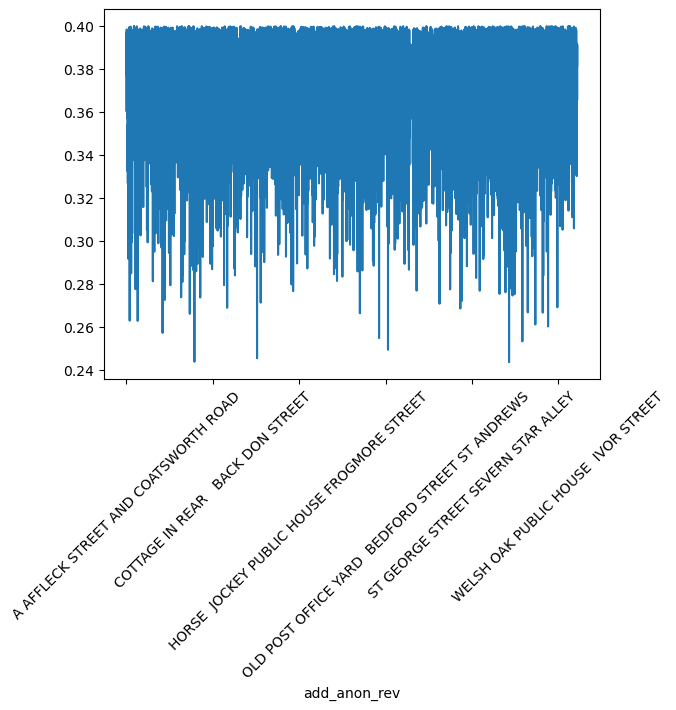

In [253]:
census_tfidf[(census_tfidf["add_anon_rev"].str.contains("STREET")) & (census_tfidf["tfidf"] < 0.4)].groupby(['add_anon_rev'])["tfidf"].mean().plot(rot=45)

In [220]:
census_tfidf[census_tfidf["add_anon_rev"].str.len() < 7].groupby("add_anon_rev").size().nlargest()

add_anon_rev
STREET    179
PENLAN    108
TYMAWR     94
COMMON     79
PENTRE     75
dtype: int64

In [219]:
census_tfidf.nlargest(1000, columns = "tfidf")

,add_anon_rev,tfidf
22260,WESTBURY B,1.0
150826,THRIPLANDS,1.0
156813,W LODGE,1.0
211807,SCHOOL,1.0
302769,BOLTONS,1.0
...,...,...
4767100,MOUSEHILL,1.0
4767207,INGLESIDE,1.0
4767212,HEATHVIEW,1.0
4767604,CRAMHURST,1.0


In [290]:
census_tfidf_test.nsmallest(400000, columns = "tfidf")

,index,add_anon_rev,tfidf
509557,15176328,HOUSES ON LICHFIELD PART OF RAILWAY STATION BU...,0.099919
509556,15176318,HOUSES ON LICHFIELD RAILWAY STATION MASTERS HO...,0.102206
509558,15176333,SUDBURY DAIRY TO HOUSES ON THE LICHFIELD MAIN ...,0.102918
704177,23280288,OLDHAM INDUSTRIAL CORPORATION FACTORY LTD IN O...,0.103733
448013,13791721,WEIGH BRIDGE CYCLE SHOP BLIND MAKER SHOP STATI...,0.104443
...,...,...,...
533565,16163086,OLD BANK BANK STREET,0.235086
728416,24287860,BOLTON STREET WEST,0.235086
600570,18423669,FIRBECK FARM HOUSE,0.235086
151669,6729884,CHURCH VIEW CHURCH LANE,0.235087


In [291]:
census_tfidf_test[census_tfidf_test["add_anon_rev"] == "CHURCH VIEW CHURCH LANE"]

,index,add_anon_rev,tfidf
151669,6729884,CHURCH VIEW CHURCH LANE,0.235087
434405,13484331,CHURCH VIEW CHURCH LANE,0.235087


In [281]:
census_tfidf["tfidf"].describe().round(3)

count    1035033.000
mean           0.600
std            0.153
min            0.230
25%            0.474
50%            0.602
75%            0.675
max            1.000
Name: tfidf, dtype: float64

In [174]:
census_tfidf[census_tfidf["add_anon_rev"] == "STREET"]

,add_anon_rev,tfidf


In [3]:
linked_all = pd.read_csv("../Lancashire_tf_idf_trial.tsv", sep = "\t")

# rapidfuzzy_wratio_s
# rapidfuzzy_wratio_ws

linked_all_maxonly = linked_all[
    linked_all["rapidfuzzy_wratio_s"]
    == linked_all.groupby("unique_add_id")[
        "rapidfuzzy_wratio_s"
    ].transform("max")
]
linked = linked_all_maxonly.drop_duplicates(
    subset=["unique_add_id"], keep=False
)

linked_all_maxonly_ws = linked_all[
    linked_all["rapidfuzzy_wratio_ws"]
    == linked_all.groupby("unique_add_id")[
        "rapidfuzzy_wratio_ws"
    ].transform("max")
]
linked_ws = linked_all_maxonly_ws.drop_duplicates(
    subset=["unique_add_id"], keep=False
)

In [4]:
linked

,Unnamed: 0,final_text,unique_add_id,gb1900_EW_1901,add_anon,tfidf,rapidfuzzy_wratio_s,rapidfuzzy_wratio_ws
12,161792,BOWER STREET,A A BOWER STREET_108038_4550006,57e8405c2c66dc5ef4004590_108038_4550006,A A BOWER STREET,0.599126,0.950,0.569169
14,524051,GLADSTONE ROAD,A B GLADSTONE ROAD_108129_4610001,58447d672c66dc145f00f463_108129_4610001,A B GLADSTONE ROAD,0.631785,0.950,0.600196
59,1750308,WHALLEY NEW ROAD,A B WHALLEY NEW ROAD_108205_4740004,58436e2d2c66dc145f00839e_108205_4740004,A B WHALLEY NEW ROAD,0.544716,0.950,0.517480
67,1233158,OLDHAM ROAD,A A A OLDHAM ROAD_108145_4670003,58e4bb712c66dcf8fa0a844b_108145_4670003,A A A OLDHAM ROAD,0.649148,0.900,0.584234
70,509496,ABBEY LANE,A ABBEY LANE_108126_4600003,58796d712c66dc67e2033bd3_108126_4600003,A ABBEY LANE,0.661964,0.950,0.628866
...,...,...,...,...,...,...,...,...
1996777,1296829,BACK GROSVENOR STREET,ZETLAND STREET_108146_4680006,580a96ea2c66dc1ce501e34d_108146_4680006,ZETLAND STREET,0.587340,0.855,0.502176
1996808,1181562,ZINC STREET,ZINC STREET_108143_4660003,58552aeb2c66dc10b800a163_108143_4660003,ZINC STREET,0.577442,1.000,0.577442
1996821,1577473,ZION STREET,ZION STREET_108155_4710002,587e84e12c66dc67e2059de3_108155_4710002,ZION STREET,0.584440,1.000,0.584440
1996829,1640305,ZION STREET,ZION STREET_108157_4720002,590705582c66dcf8fa122191_108157_4720002,ZION STREET,0.584440,1.000,0.584440


In [16]:
linked[linked["rapidfuzzy_wratio_s"].between(0.89, 0.899)]

,Unnamed: 0,final_text,unique_add_id,gb1900_EW_1901,add_anon,tfidf,rapidfuzzy_wratio_s,rapidfuzzy_wratio_ws
15207,1541270,ELLIOTT STREET,A ELLIOT STREET_108155_4700006,58fbbe2d2c66dcf8fa0fe168_108155_4700006,A ELLIOT STREET,0.590140,0.896552,0.529091
15208,36796,ELLIOT STREET,A ELLIOTT STREET_108035_4530005,57eecafe2c66dca322009ec7_108035_4530005,A ELLIOTT STREET,0.596246,0.896552,0.534565
15271,317033,ELLAMSBRIDGE ROAD,A ELLLAMS BRIDGE ROAD_108069_4560006,58de188f2c66dcf8fa0885cb_108069_4560006,A ELLLAMS BRIDGE ROAD,0.506824,0.894737,0.453474
16918,1097211,GOODIER'S LANE,A GOODIERS LANE_108142_4650004,58da96022c66dcf8fa07ac86_108142_4650004,A GOODIERS LANE,0.634146,0.896552,0.568544
20390,1204548,HARROLD STREET,A HAROLD STREET_108144_4670001,58e7a2b32c66dcf8fa0b371a_108144_4670001,A HAROLD STREET,0.595210,0.896552,0.533636
...,...,...,...,...,...,...,...,...
1887234,1719749,WHALLEY STREET,WALMSLEY STREET_108205_4740004,58436c732c66dc145f0082cf_108205_4740004,WALMSLEY STREET,0.598606,0.896552,0.536681
1889115,226689,WARRINGTON ROAD,WANINGTON ROAD_108065_4560004,5804e1de2c66dcab3d081c9a_108065_4560004,WANINGTON ROAD,0.601168,0.896552,0.538978
1889297,1020604,BURTON STREET,WARBURTON STREET_108140_4650001,58c64d022c66dcf8fa0186bb_108140_4650001,WARBURTON STREET,0.591277,0.896552,0.530110
1948772,1655145,CLIFFE STREET,WICKLIFFE STREET_108160_4720004,5848853f2c66dc0ad4012df7_108160_4720004,WICKLIFFE STREET,0.579890,0.896552,0.519901


In [12]:
linked.describe()

,Unnamed: 0,tfidf,rapidfuzzy_wratio_s,rapidfuzzy_wratio_ws
count,4.655900e+04,46559.000000,46559.000000,46559.000000
mean,1.079214e+06,0.584072,0.940295,0.551318
std,6.347397e+05,0.112806,0.052788,0.120545
min,0.000000e+00,0.273200,0.850000,0.245880
25%,4.941285e+05,0.513708,0.900000,0.468333
50%,1.147830e+06,0.588847,0.950000,0.562679
75%,1.669792e+06,0.636897,1.000000,0.613997
max,1.996840e+06,1.000000,1.000000,1.000000


In [367]:
testing = pd.concat([linked, linked_ws]).drop_duplicates(keep = False)
testing

,Unnamed: 0,final_text,unique_add_id,gb1900_EW_1901,add_anon,tfidf,rapidfuzzy_wratio_s,rapidfuzzy_wratio_ws
